In [288]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
    

In [290]:
df = pd.read_excel("Base_Final.xlsx")
df.head()

,WEEK,ITEM_CODE,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION,MANUFACTURER,BRAND,ITEM,ITEM_DESCRIPTION,...,ATTR2,ATTR3,CATEGORY_ID,CATEGORY_y,SEGMENT,YEAR,MONTH,WEEK_NUMBER,DATE,YEAR_MONTH
0,34-22,7501058792808BP2,0.006,0.139,1.000,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058792808BP2,VANISHOXIACTIONROSADOYPACK120GR+MMCRYSTALWHITE...,...,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANIT,POWDER,2022,8,34,2022-08-28,2022-08
1,34-22,7501058715883,0.487,116.519,2.916,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058715883,VANISH OXI ACTION GOLD QUITAMANCHAS BOLSA 1.8K...,...,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANIT,POWDER,2022,8,34,2022-08-28,2022-08
2,34-22,7702626213774,1.391,68.453,5.171,TOTAL AUTOS AREA 5,RECKITT,VANISH,7702626213774,VANISH OXI ACTION ROSA QUITAMANCHAS DOYPACK 24...,...,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANIT,POWDER,2022,8,34,2022-08-28,2022-08
3,34-22,7501058716422,0.022,1.481,1.833,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058716422,VANISH OXI ACTION GOLD QUITAMANCHA AHORRO DEL ...,...,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANIT,POWDER,2022,8,34,2022-08-28,2022-08
4,34-22,7501058784353,2.037,182.839,5.375,TOTAL AUTOS AREA 5,RECKITT,VANISH,7501058784353,VANISH INTELLIGENCE POLVO BOTE 450 GR NAL 7501...,...,FABRIC TREATMENT,ROSA,1,FABRIC TREATMENT AND SANIT,POWDER,2022,8,34,2022-08-28,2022-08


<Axes: xlabel='DATE'>

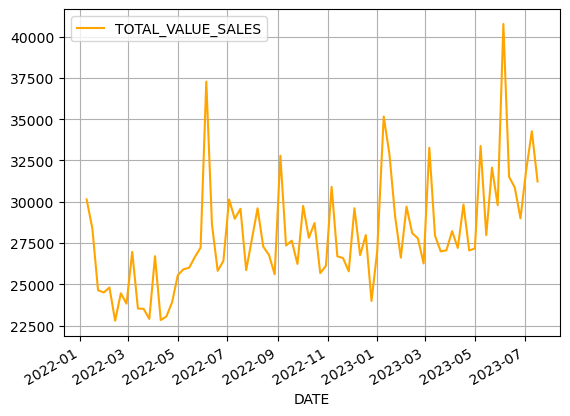

In [291]:
# Data filtration by BRAND (Vanish and Lysol*
productos_reckitt = ['VANISH','LYSOL']
df = df[df['BRAND'].isin(productos_reckitt)]


# Date unit transformation
df['DATE'] = pd.to_datetime(df['DATE'])

# Grouping by DATE
df= df.groupby(['DATE']).agg({'TOTAL_VALUE_SALES':'sum'})

# General plot of total value sales in time
df.plot(grid=True, color='orange')

In [ ]:
serie = df
n = len(serie)
split = int(n * 0.7)
train = serie.iloc[:split]
test = serie.iloc[split:]
serie


In [244]:

# ------------------------------
# 3. Prueba Dickey-Fuller
# ------------------------------
def adf_test(x):
    res = adfuller(x, autolag="AIC")
    return res[0], res[1]

d = 0
serie_aux = train.copy()

print("Prueba Dickey-Fuller:")
while True:
    stat, pvalue = adf_test(serie_aux.dropna())
    print(f"d = {d} | Estadístico ADF = {stat:.4f} | p-value = {pvalue:.4f}")
    if pvalue < 0.05:
        break
    serie_aux = serie_aux.diff()
    d += 1


Prueba Dickey-Fuller:
d = 0 | Estadístico ADF = -1.7597 | p-value = 0.4007
d = 1 | Estadístico ADF = -2.2729 | p-value = 0.1809
d = 2 | Estadístico ADF = -3.1876 | p-value = 0.0207


In [246]:
# ------------------------------
# 4. Comparación ARIMA(p,d,q) con AIC
# ------------------------------
resultados = []

for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = SARIMAX(train, order=(p, d, q),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            res = model.fit(disp=False)
            resultados.append([p, 1, q, res.aic])
        except:
            continue

aic_df = pd.DataFrame(resultados, columns=["p", "d", "q", "AIC"])
aic_df = aic_df.sort_values("AIC")
aic_df.head(6)


,p,d,q,AIC
15,3,1,3,948.441650
11,2,1,3,954.280907
3,0,1,3,956.735230
7,1,1,3,957.265058
14,3,1,2,961.227556
6,1,1,2,976.168159


In [248]:
# ------------------------------
# 5. Ajustar mejor modelo
# ------------------------------
p_opt, d_opt, q_opt = aic_df.iloc[0][["p", "d", "q"]]

modelo = SARIMAX(train, order=(p_opt, d_opt, q_opt),
                 enforce_stationarity=False,
                 enforce_invertibility=False)
fit = modelo.fit(disp=False)

In [284]:

# ------------------------------
# 6. Pronósticos
# ------------------------------
h = len(test)
forecast = fit.get_forecast(steps=h)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

pred.index = test.index
conf_int.index = test.index
pred

DATE
2023-02-06    30319.816157
2023-02-13    31494.337283
2023-02-20    30653.294358
2023-02-27    28789.332341
2023-03-06    29415.466754
2023-03-13    30295.160825
2023-03-20    30530.389865
2023-03-27    29766.077371
2023-04-03    29595.976314
2023-04-10    29873.035689
2023-04-17    30181.727117
2023-04-24    30010.093648
2023-05-01    29829.426442
2023-05-08    29834.042524
2023-05-15    29987.613682
2023-05-22    30002.456663
2023-05-29    29930.791747
2023-06-05    29883.897820
2023-06-12    29927.300336
2023-06-19    29961.014796
2023-06-26    29950.398785
2023-07-03    29920.726680
2023-07-10    29922.401277
2023-07-17    29938.831099
Name: predicted_mean, dtype: float64

In [252]:
# ------------------------------
# 7. Métricas de error
# ------------------------------

pred = pred.values        # elimina índice
test_vals = test.values

mae = np.mean(np.abs(test_vals - pred))
rmse = np.sqrt(np.mean((test_vals - pred) ** 2))
mape = np.mean(np.abs((test_vals - pred) / test_vals)) * 100

print("\nMétricas de error:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")


Métricas de error:
MAE  = 2483.8671
RMSE = 3234.4505
MAPE = 8.06%


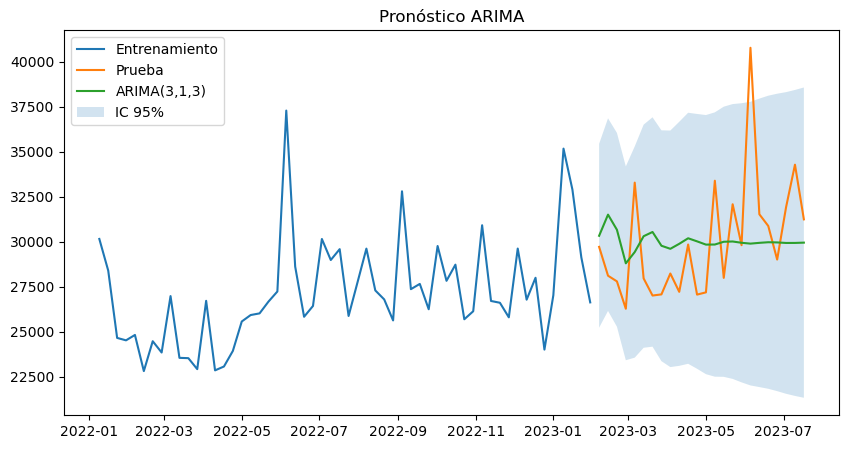

In [280]:
# ------------------------------
# 8. Gráfica final
# ------------------------------
pred = pd.Series(pred, index=test.index)

# Definir intervalo de tiempo
inicio = "2018-01-01"
fin = "2020-12-31"

train_g = train.loc[inicio:fin]
test_g = test.loc[inicio:fin]
pred_g = pred.loc[inicio:fin]
conf_g = conf_int.loc[inicio:fin]

plt.figure(figsize=(10, 5))
plt.plot(train, label="Entrenamiento")
plt.plot(test, label="Prueba")
plt.plot(pred, label=f"ARIMA({int(p_opt)},{int(d_opt)},{int(q_opt)})")
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 alpha=0.2,
                 label="IC 95%")
plt.legend()
plt.title("Pronóstico ARIMA")
plt.show()

In [282]:
# Número de predicciones
n_forecast = 8

# Última fecha observada
ultima_fecha = train.index[-1]

# Frecuencia de la serie (ej. 'M', 'D', 'W')
freq = train.index.freq
# Crear fechas futuras
fechas_futuras = pd.date_range(start=ultima_fecha,
                               periods=n_forecast + 1,
                               freq=freq)[1:]
#Prediccines
forecast_8 = fit.get_forecast(steps=n_forecast)

pred_8 = forecast_8.predicted_mean
conf_8 = forecast_8.conf_int()

# Asignar las fechas
pred_8.index = fechas_futuras
conf_8.index = fechas_futuras
predicciones = pd.DataFrame({
    "Pronóstico": pred_8,
    "LI_95%": conf_8.iloc[:, 0],
    "LS_95%": conf_8.iloc[:, 1]
})
predicciones

,Pronóstico,LI_95%,LS_95%
2023-01-31,30319.816157,25213.457559,35426.174756
2023-02-01,31494.337283,26144.467388,36844.207177
2023-02-02,30653.294358,25270.804471,36035.784245
2023-02-03,28789.332341,23406.715683,34171.948999
2023-02-04,29415.466754,23549.708720,35281.224788
2023-02-05,30295.160825,24098.948161,36491.373489
2023-02-06,30530.389865,24159.936161,36900.843569
2023-02-07,29766.077371,23354.951184,36177.203557
